# Temporal Analysis

What happens over time?

## Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
from bookgender.config import db_uri

## Load the Data

In [4]:
az_rates = pd.read_parquet('data/AZ/ratings.parquet')
print('sorting amazon ratings')
az_rates.sort_values('timestamp', inplace=True)
print('timestampifying Amazon actions')
az_rates['timestamp'] = pd.to_datetime(az_rates['timestamp'], unit='s')
az_rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22464284 entries, 6941990 to 21090668
Data columns (total 4 columns):
user         int64
item         int64
rating       float64
timestamp    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 856.9 MB


In [5]:
gr_rates = pd.read_parquet('data/GR-I/ratings.parquet')
gr_rates.info()

sorting GoodReads actions


KeyError: 'timestamp'

In [7]:
print('sorting GoodReads actions')
gr_rates.sort_values('first_time', inplace=True)
print('timestampifying GoodReads actions')
gr_rates['timestamp'] = pd.to_datetime(gr_rates['first_time'], unit='s')
gr_rates.info()

sorting GoodReads actions
timestampifying GoodReads actions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 188962927 entries, 26747886 to 184734437
Data columns (total 6 columns):
user          int64
item          int64
nactions      int64
first_time    int64
last_time     int64
timestamp     datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 9.9 GB


Load the gender info:

In [10]:
gender = pd.read_parquet('data/author-gender.parquet')
gender = gender.set_index('item')['gender']
gender[gender.str.startswith('no-')] = 'unlinked'
gender = gender.astype('category')
gender.describe()

count     11786290
unique           5
top       unlinked
freq       5621867
Name: gender, dtype: object

In [42]:
az_j = az_rates.set_index('timestamp')[['user', 'item']].join(gender, on='item', how='left')
az_j['gender'].fillna('unlinked', inplace=True)

In [44]:
gr_j = gr_rates.set_index('timestamp')[['user', 'item']].join(gender, on='item', how='left')
gr_j['gender'].fillna('unlinked', inplace=True)

## Evolution over Time

In [15]:
az_counts = az_j.resample('1M')['item'].count()
az_counts.head()

timestamp
1996-05-31    2
1996-06-30    3
1996-07-31    0
1996-08-31    1
1996-09-30    1
Freq: M, Name: item, dtype: int64

In [45]:
gr_counts = gr_j.resample('1M')['item'].count()
gr_counts.head()

timestamp
2006-08-31     18
2006-09-30     12
2006-10-31     12
2006-11-30     13
2006-12-31    299
Freq: M, Name: item, dtype: int64

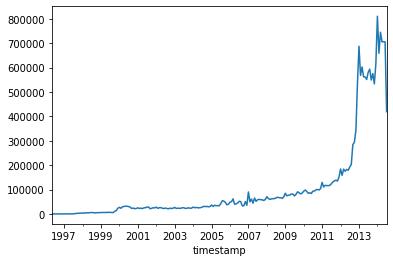

In [16]:
az_counts.plot()

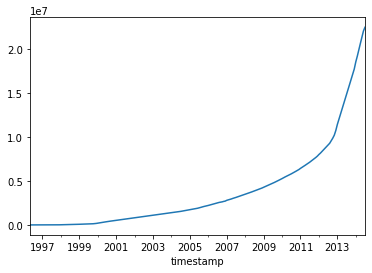

In [43]:
az_counts.cumsum().plot()

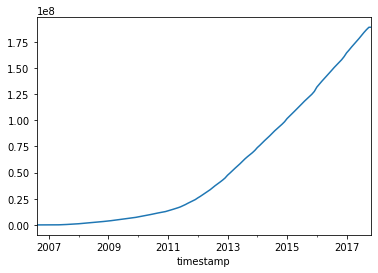

In [46]:
gr_counts.cumsum().plot()

In [18]:
az_gcounts = az_j.resample('1M').apply(lambda df: df.groupby('gender')['item'].count())
az_gcounts.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0,0,2,0,0
1996-06-30,0,0,3,0,0
1996-07-31,0,0,0,0,0
1996-08-31,0,1,0,0,0
1996-09-30,0,0,1,0,0


In [47]:
gr_gcounts = gr_j.resample('1M').apply(lambda df: df.groupby('gender')['item'].count())
gr_gcounts.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
2006-08-31,3,1,12,2,0
2006-09-30,2,1,9,0,0
2006-10-31,2,0,8,0,2
2006-11-30,0,4,7,2,0
2006-12-31,21,36,229,1,12


In [32]:
az_gcc = az_gcounts.cumsum()
az_gcc.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0,0,2,0,0
1996-06-30,0,0,5,0,0
1996-07-31,0,0,5,0,0
1996-08-31,0,1,5,0,0
1996-09-30,0,1,6,0,0


In [48]:
gr_gcc = gr_gcounts.cumsum()
gr_gcc.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
2006-08-31,3,1,12,2,0
2006-09-30,5,2,21,2,0
2006-10-31,7,2,29,2,2
2006-11-30,7,6,36,4,2
2006-12-31,28,42,265,5,14


In [33]:
az_cc = az_counts.cumsum()

Look at # of ratings over time:

In [49]:
def stack(df, ax=plt):
    ax.stackplot(df.index, df.T, labels=df.columns)
    ax.legend()

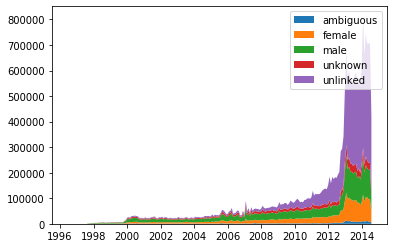

In [50]:
stack(az_gcounts)

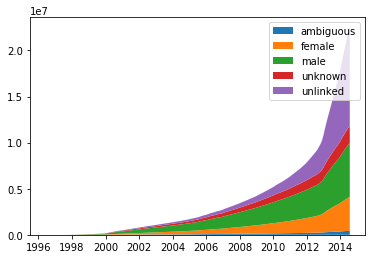

In [51]:
stack(az_gcc)

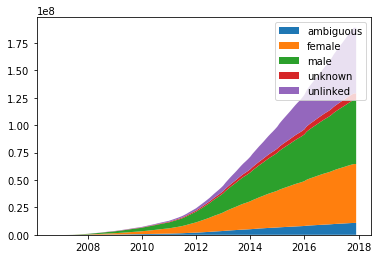

In [52]:
stack(gr_gcc)

And fraction:

In [29]:
az_gfrac = az_gcounts.divide(az_counts, axis=0).dropna()
az_gfrac.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0.0,0.000000,1.000000,0.0,0.0
1996-06-30,0.0,0.000000,1.000000,0.0,0.0
1996-08-31,0.0,1.000000,0.000000,0.0,0.0
1996-09-30,0.0,0.000000,1.000000,0.0,0.0
1996-11-30,0.0,0.166667,0.833333,0.0,0.0


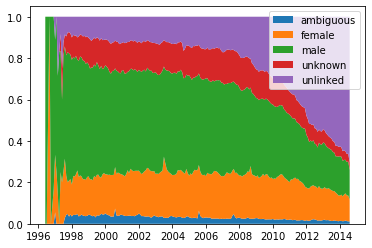

In [37]:
stack(az_gfrac)

Fraction of Known:

In [27]:
az_k = az_gcounts[['female', 'male']]
az_kfrac = az_k.divide(az_k.sum(axis=1), axis=0).dropna()
az_kfrac.head()

gender,female,male
timestamp,,
1996-05-31,0.000000,1.000000
1996-06-30,0.000000,1.000000
1996-08-31,1.000000,0.000000
1996-09-30,0.000000,1.000000
1996-11-30,0.166667,0.833333


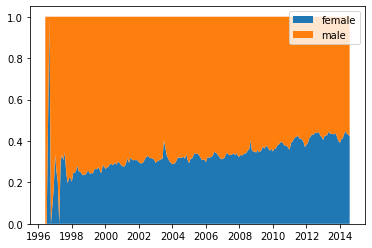

In [38]:
stack(az_kfrac)

Cumulative fractions:

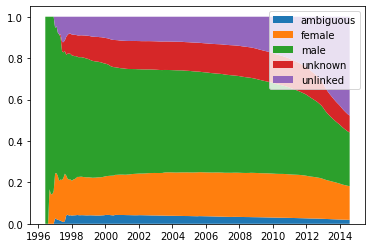

In [39]:
az_cf = az_gcc.divide(az_cc, axis=0)
stack(az_cf)

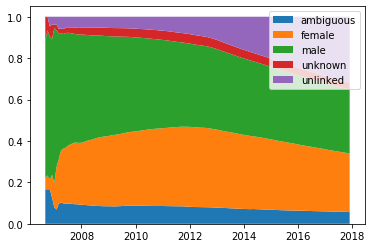

In [65]:
gr_cf = gr_gcc.divide(gr_counts.cumsum(), axis=0)
stack(gr_cf)

In [40]:
az_kcf = az_k.cumsum().divide(az_k.sum(axis=1).cumsum(), axis=0).dropna()
az_kcf.head()

gender,female,male
timestamp,,
1996-05-31,0.000000,1.000000
1996-06-30,0.000000,1.000000
1996-07-31,0.000000,1.000000
1996-08-31,0.166667,0.833333
1996-09-30,0.142857,0.857143


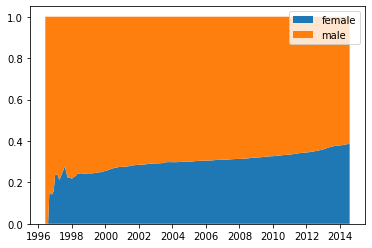

In [41]:
stack(az_kcf)

In [67]:
gr_k = gr_gcounts[['female', 'male']]
gr_kcf = gr_k.cumsum().divide(gr_k.sum(axis=1).cumsum(), axis=0).dropna()
gr_kcf.head()

gender,female,male
timestamp,,
2006-08-31,0.076923,0.923077
2006-09-30,0.086957,0.913043
2006-10-31,0.064516,0.935484
2006-11-30,0.142857,0.857143
2006-12-31,0.136808,0.863192


The recommender was added to GoodReads on September 15:

In [74]:
gr_rec = pd.to_datetime('2011-09-15')

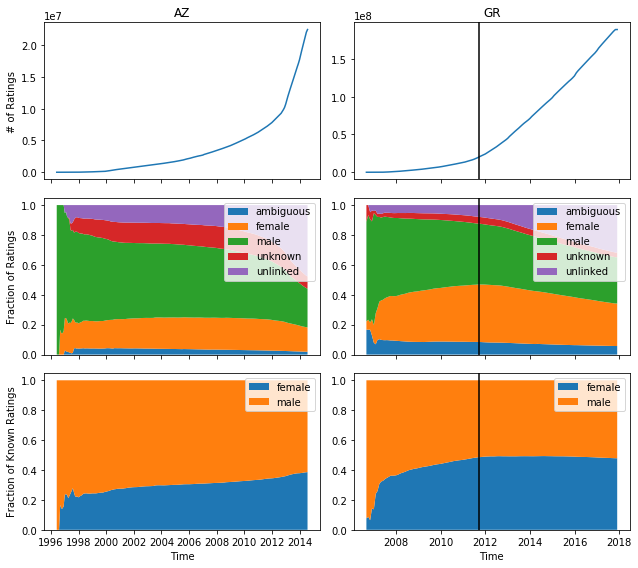

In [78]:
fig, axs = plt.subplots(3, 2, sharex='col', figsize=[9, 8])
sns.lineplot(data=az_counts.cumsum(), ax=axs[0, 0])
sns.lineplot(data=gr_counts.cumsum(), ax=axs[0, 1])
axs[0, 0].set_ylabel('# of Ratings')

stack(az_cf, ax=axs[1, 0])
stack(gr_cf, ax=axs[1, 1])
axs[1, 0].set_ylabel('Fraction of Ratings')

stack(az_kcf, ax=axs[2, 0])
stack(gr_kcf, ax=axs[2, 1])
axs[2, 0].set_ylabel('Fraction of Known Ratings')

axs[2, 0].set_xlabel('Time')
axs[2, 1].set_xlabel('Time')

axs[0, 0].set_title('AZ')
axs[0, 1].set_title('GR')

for r in range(3):
    axs[r, 1].axvline(gr_rec, 0, 1, color='black')

plt.tight_layout()

## Books over Time

In [81]:
book_year = pd.read_sql('''
    SELECT cluster AS item, min(pub_year) AS pub_year
    FROM locmds.book_pub_year
    JOIN locmds.book_rec_isbn USING (rec_id)
    JOIN isbn_cluster USING (isbn_id)
    GROUP BY cluster
''', db_uri())
book_year.head()

,item,pub_year
0,201761454,2008
1,114293136,1982
2,113908707,1984
3,111276590,2003
4,101891138,2006


In [85]:
book_yg = book_year.join(gender, on='item', how='left')
book_yg['gender'].fillna('unknown', inplace=True)
book_yg['pub_year'] = book_yg['pub_year'].astype('i4')
book_yg.head()

,item,pub_year,gender
0,201761454,2008,male
1,114293136,1982,male
2,113908707,1984,unknown
3,111276590,2003,unknown
4,101891138,2006,female


In [86]:
book_yg = book_yg[book_yg.pub_year < 2015]
book_yg = book_yg[book_yg.pub_year > 1960]

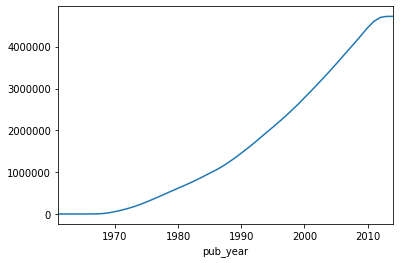

In [87]:
y_counts = book_yg.groupby('pub_year').item.count()
y_counts.cumsum().plot()

In [90]:
y_gc = book_yg.groupby(['pub_year', 'gender']).item.count().unstack()
y_gc.head()

gender,ambiguous,female,male,unknown,unlinked
pub_year,,,,,
1961,9,13,118,23,18
1962,4,21,136,39,27
1963,9,19,173,40,23
1964,8,34,157,36,44
1965,11,27,203,68,43


In [92]:
y_gcc = y_gc.cumsum()
y_gcf = y_gcc.divide(y_counts.cumsum(), axis=0)
y_gcf.head()

gender,ambiguous,female,male,unknown,unlinked
pub_year,,,,,
1961,0.049724,0.071823,0.651934,0.127072,0.099448
1962,0.031863,0.083333,0.622549,0.151961,0.110294
1963,0.032738,0.078869,0.635417,0.151786,0.101190
1964,0.031546,0.091483,0.614090,0.145110,0.117771
1965,0.031466,0.087490,0.603991,0.158097,0.118956


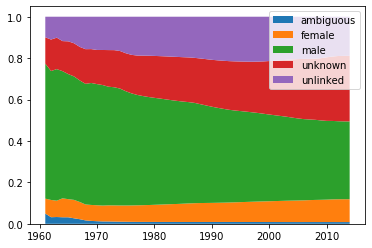

In [93]:
stack(y_gcf)